# Perkenalan

Nama : Salman Faishal

Batch : FTDS-017-RMT

Dataset: Bitcoin Tweets

Obj : membuat sentiment analysis apakah tweet yang di unggah adalah sentiment positif, netral atau negatif 

Deployment : [Bitcoin Tweets Sentiment](https://huggingface.co/spaces/salmanfaishal27/bitcoin)

# Import Libraries & Initial Setup

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
import pandas as pd
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from nltk.tokenize import word_tokenize
import tensorflow as tf
import math
import nltk
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM,Dropout
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\salma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\salma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Loading

In [3]:
df = pd.read_csv('bitcointweets.csv', header=None)[[1, 7]]
df.columns = ['tweet', 'label']
df['label'] = df.label.str.extract(r'(\w+)')
df.head()

,tweet,label
0,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",neutral
1,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,neutral
2,RT @tippereconomy: Another use case for #block...,positive
3,free coins https://t.co/DiuoePJdap,positive
4,RT @payvxofficial: WE are happy to announce th...,positive


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50859 entries, 0 to 50858
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   50859 non-null  object
 1   label   50859 non-null  object
dtypes: object(2)
memory usage: 794.8+ KB


## label

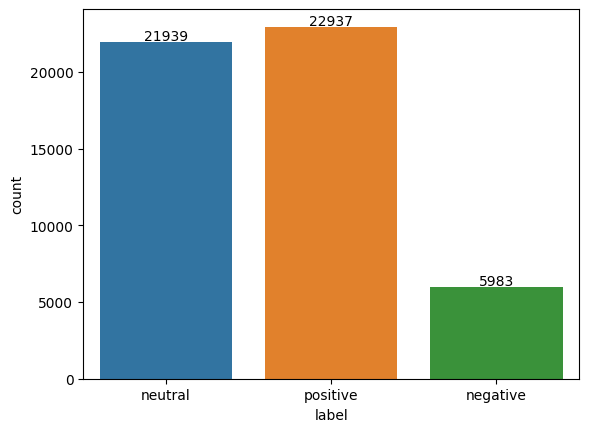

In [5]:
ax = sns.countplot(x = 'label', data = df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,height + 100, '{:1.0f}'.format(height), ha="center")

terdapat 3 label pada olom label, yaitu neutral, positive dan negative, dimana label terbanyak ada pada label positive sebesar 22937 dan terendah adalah label negative sebanyak 5983

# Data Preprocessing

## Text Preprocessing

In [6]:
def clean_text(df, text_column):
    # Define stopwords
    stpwds_en = set(stopwords.words('english'))
    # Mengubah Teks ke Lowercase
    df['clean'] = df[text_column].str.lower()
    # Menghilangkan Mention
    df['clean'] = df['clean'].apply(lambda x: re.sub(r'@\w+', '', x))
     # Menghilangkan Link
    df['clean'] = df['clean'].apply(lambda x: re.sub(r'http\S+', '', x))
    # Menghiilangkan angka
    df['clean'] = df['clean'].apply(lambda x: re.sub('\d+', '', x))
    df['clean'] = df['clean'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
     # Menghilangkan RT
    df['clean'] = df['clean'].apply(lambda x: re.sub('rt', '', x))
    # Mengubah dum b a ss menjadi dumbass
    df['clean'] = df['clean'].apply(lambda x: re.sub('dum b a ss', 'dumbass', x))
    df['clean'] = df['clean'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    df['clean'] = df['clean'].apply(lambda x: ' '.join([word for word in x.split(' ') if word not in stpwds_en]))
    return df

In [7]:
df = clean_text(df,'tweet') 
df

,tweet,label,clean
0,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",neutral,paul krugman nobel luddite tweak nose bitcoi...
1,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,neutral,dumbass said know nothing bitcoin
2,RT @tippereconomy: Another use case for #block...,positive,another use case blockchain tipper tippereco...
3,free coins https://t.co/DiuoePJdap,positive,free coins
4,RT @payvxofficial: WE are happy to announce th...,positive,happy announce payvx presale phase live\n\n...
...,...,...,...
50854,RT @fixy_app: Fixy Network brings popular cryp...,positive,fixy network brings popular cryptocurrencies...
50855,RT @bethereumteam: After a successful launch o...,positive,successful launch bounty campaign weve manag...
50856,"RT @GymRewards: Buy #GYMRewards Tokens, Bonus ...",neutral,buy gymrewards tokens bonus time ending ico...
50857,I added a video to a @YouTube playlist https:/...,positive,added video playlist bitcoin cloud mining fr...


In [8]:
df['length'] = df.clean.apply(lambda x: len(x.split(' ')))

In [9]:
df = df[df.length > 6]

In [10]:
# Menghapus data duplicate pada kolom clean
nodub = df.drop_duplicates(subset='clean')

alasan mengapa data duplikat di hapus adalah  untuk mencegah bias dalam analisis. Jika data duplikat tidak dihapus, kemungkinan besar data tersebut akan diberikan bobot yang lebih besar daripada data unik saat dilakukan analisis, sehingga dapat mempengaruhi hasil analisis dan memberikan kesimpulan yang salah.

In [11]:
nodub.head()

,tweet,label,clean,length
0,"RT @ALXTOKEN: Paul Krugman, Nobel Luddite. I h...",neutral,paul krugman nobel luddite tweak nose bitcoi...,16
1,@lopp @_Kevin_Pham @psycho_sage @naval But @Pr...,neutral,dumbass said know nothing bitcoin,13
2,RT @tippereconomy: Another use case for #block...,positive,another use case blockchain tipper tippereco...,15
4,RT @payvxofficial: WE are happy to announce th...,positive,happy announce payvx presale phase live\n\n...,12
5,Copy successful traders automatically with Bit...,positive,copy successful traders automatically bitcoin ...,11


In [12]:
y = pd.get_dummies(nodub['label']).values # encode label

In [13]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize each token in the input text
lemmatized_input = []
for sentence in nodub.clean:
    tokens = word_tokenize(sentence)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_sentence = " ".join(lemmatized_tokens)
    lemmatized_input.append(lemmatized_sentence)

# Split data into training and test sets
xtrain, xtest, ytrain, ytest = train_test_split(lemmatized_input, y, stratify=y, random_state=23, test_size=0.2)

# Tokenize the lemmatized input text
max_features = 10000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(xtrain))
X_train = tokenizer.texts_to_sequences(xtrain)
X_test = tokenizer.texts_to_sequences(xtest)

# Pad the sequences
max_words = 10
X_train_padded = pad_sequences(X_train, maxlen=max_words)
X_test_padded = pad_sequences(X_test, maxlen=max_words)

# Create TensorFlow datasets
train_set = tf.data.Dataset.from_tensor_slices((X_train_padded, ytrain))
test_set = tf.data.Dataset.from_tensor_slices((X_test_padded, ytest))

# Exploratory Data Analysis (EDA) setelah data preprocessing

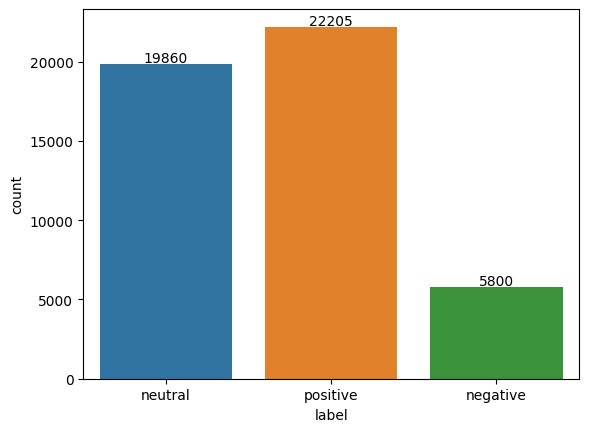

In [14]:
ax = sns.countplot(x = 'label', data = df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,height + 100, '{:1.0f}'.format(height), ha="center")

Setelah dilakukan preprocessing jumlah dari masing masing label berubah, untuk label positive menjadi 22205 yang asalnya 22937, neutral dari 21939 menjadi 19860 dan negative menjadi 5800 yang asalnya 5983, namu jumlah terbanyak masih terdapat pada label positive dan terendah tetap berada di negative, label terbanyak yang kehilangan datanya adalah label neutral dengan jumlah data dihapus 2079 karena memiliki duplikasi data

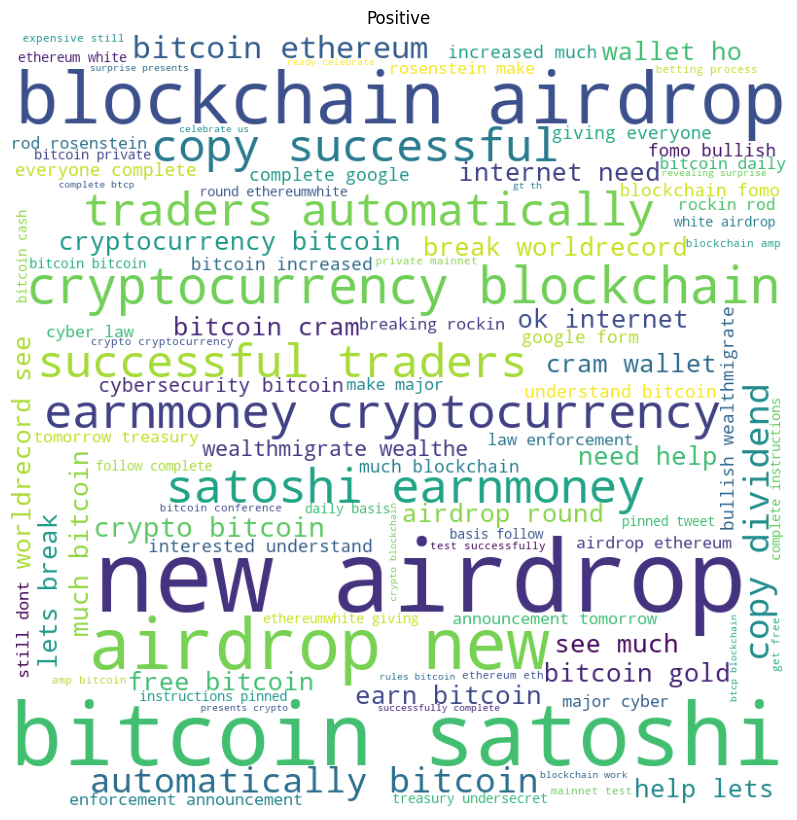

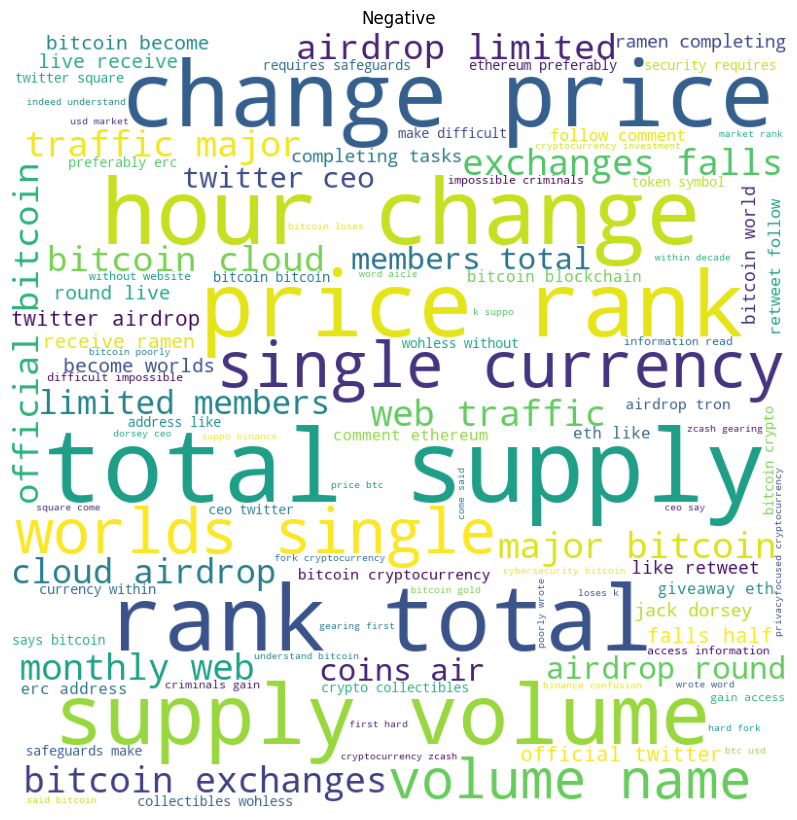

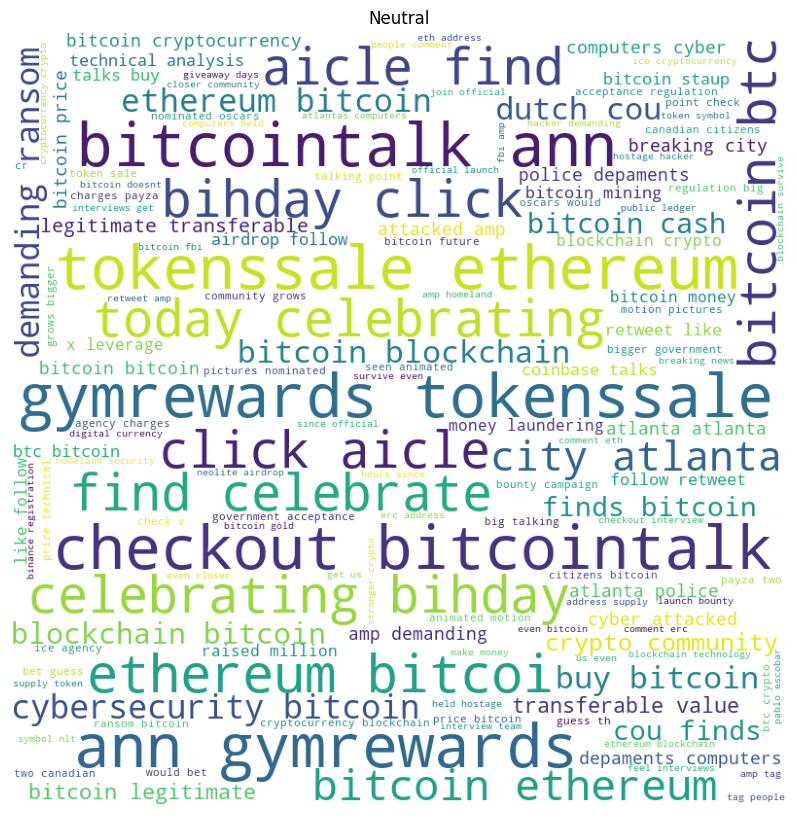

In [15]:
stpwds_en = set(stopwords.words('english'))
df_label1 = df[df['label'] == 'positive']
df_label2 = df[df['label'] == 'negative']
df_label3 = df[df['label'] == 'neutral']

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stpwds_en, min_font_size = 10).generate(text)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.tight_layout(pad = 0)
    plt.show()
generate_wordcloud(' '.join(df_label1['clean']), 'Positive')
generate_wordcloud(' '.join(df_label2['clean']), 'Negative')
generate_wordcloud(' '.join(df_label3['clean']), 'Neutral')

- Kata Positif paling banyak adalah bitcoin sathoshi, new airdrop, airdrop new, hampir semua kata positif didominasi oleh kata airdrop, yang dimana airdrop menurut zipmex.com adalah airdrop adalah pemberian crypto asset pada sebagian orang atau komunitas yang diberikan secara cuma-cuma.

- Kata Negative paling banyak adalah supply volume, total supply, change price, price rank
- Kata netral paling banyak adalah find celebrate, bitcointalk, click aicle

# Model Definition

## Base Model Sequential

In [16]:
# Model Training dengan Menggunakan LSTM

model_lstm1 = Sequential()
model_lstm1.add(Embedding(max_features, 50, input_length=X_train_padded.shape[1]))
model_lstm1.add(LSTM(128, return_sequences=True))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(LSTM(32))
model_lstm1.add(Dropout(0.5))
model_lstm1.add(Dense(3,activation='softmax'))

model_lstm1.compile(loss='categorical_crossentropy',optimizer='adam',metrics='accuracy')
print(model_lstm1.summary())

model_lstm1_history = model_lstm1.fit(X_train_padded, ytrain, epochs=20, validation_data=(X_test_padded, ytest),callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 50)            500000    
                                                                 
 lstm (LSTM)                 (None, 10, 128)           91648     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 612,355
Trainable params: 612,355
Non-trai

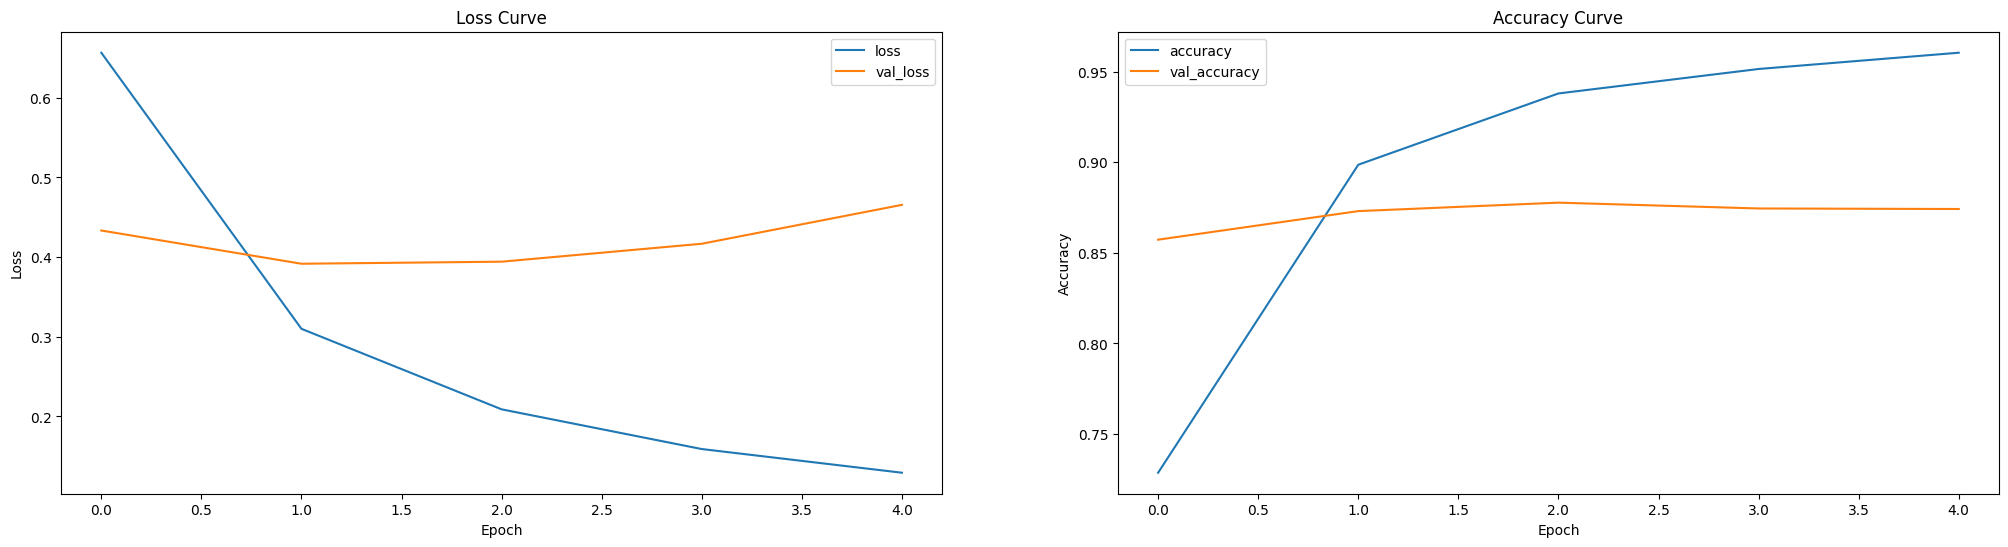

In [17]:
metrics = pd.DataFrame(model_lstm1_history.history)

fig, ax = plt.subplots(1, 2, figsize=(25, 6))
metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss Curve', xlabel='Epoch', ylabel='Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
plt.show()

In [18]:
# Get predicted class labels
lstm_pred_train_seq = model_lstm1.predict(X_train_padded)
lstm_pred_test_seq = model_lstm1.predict(X_test_padded)
lstm_pred_train_1 = lstm_pred_train_seq.argmax(axis=-1)
lstm_pred_test_1 = lstm_pred_test_seq.argmax(axis=-1)

# Calculate classification metrics
print(classification_report(ytrain.argmax(axis=1), lstm_pred_train_1))
print(classification_report(ytest.argmax(axis=1), lstm_pred_test_1))

108/108 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      1721
           1       0.93      0.99      0.96      6431
           2       0.96      0.94      0.95      5550

    accuracy                           0.95     13702
   macro avg       0.95      0.92      0.93     13702
weighted avg       0.95      0.95      0.95     13702

              precision    recall  f1-score   support

           0       0.87      0.59      0.70       430
           1       0.86      0.95      0.90      1608
           2       0.89      0.87      0.88      1388

    accuracy                           0.87      3426
   macro avg       0.87      0.80      0.83      3426
weighted avg       0.87      0.87      0.87      3426



108/108 [==============================] - 0s 3ms/step


Text(70.72222222222221, 0.5, 'Actual')

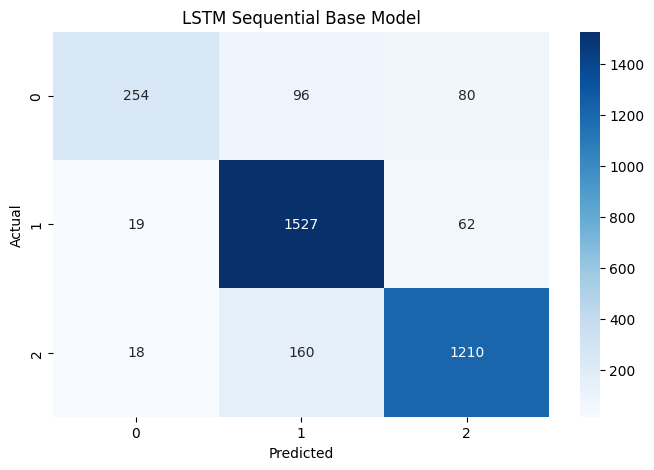

In [19]:
# Predict classes for test set
y_pred1 = model_lstm1.predict(X_test_padded)
y_pred1 = np.argmax(y_pred1, axis=1)

# Generate confusion matrix
cm_bm = confusion_matrix(np.argmax(ytest, axis=1), y_pred1)
plt.figure(figsize=(8, 5))
sns.heatmap(cm_bm,annot=True,fmt='d',cmap='Blues')
plt.title('LSTM Sequential Base Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')


penjelasan step pada model :
 - Inisialisasi model Sequential dengan nama "model_lstm1"
 - Menambahkan layer Embedding dengan parameter max_features, 50, dan input_length sesuai dengan ukuran data X_train_padded. Layer Embedding digunakan untuk mengubah representasi integer dari setiap kata dalam teks menjadi vektor numerik yang lebih kompak.
 - Menambahkan layer LSTM dengan 128 unit dan return_sequences=True. return_sequences=True menunjukkan bahwa output dari setiap time step harus dikembalikan sebagai input untuk time step berikutnya
 - Menambahkan layer Dropout dengan tingkat dropout 0.5. Layer Dropout digunakan untuk mencegah overfitting pada model.
 - Menambahkan layer LSTM dengan 32 unit.
 - Menambahkan layer Dropout dengan tingkat dropout 0.5.
 - Menambahkan layer Dense dengan 3 unit dan aktivasi 'softmax'. Layer Dense ini bertugas mengklasifikasikan data menjadi 3 kelas berdasarkan hasil softmax.
 - Compile model dengan memilih loss function categorical_crossentropy dan optimizer 'adam', serta melihat accuracy sebagai metric evaluasi.
 - Melatih model dengan fit method dengan data X_train_padded dan ytrain, selama 20 epochs dan melihat validasi pada data X_test_padded dan ytest. Callback EarlyStopping juga digunakan untuk menghentikan pelatihan apabila tidak ada peningkatan pada val_loss dalam jumlah patience (3).

Model ini menghasilkan train set sebesat 0.95 dan 0.87, bisa dikatan model ini overfitting, meskipun sudah ditambahkan layer dropout untuk mencegah overfitting namun model ini belum mampu untuk menghidari overfitting
pada confusion matrix, model ini mampu memberikan prediksi benar pada label 0 (negatif) sebanyak 254, prediksi benar pada label 1 (neutral) sebanyak 1527 dan prediksi pada label 2 (positif) sebanyak 1210.


## Model Improvement

### Model Improvement lstm sequential 1

In [20]:
model_imp_1 = Sequential()
model_imp_1.add(Embedding(max_features, 50, input_length=X_train_padded.shape[1]))
model_imp_1.add(Conv1D(filters=18, kernel_size=3, padding='same', activation='relu'))
model_imp_1.add(MaxPooling1D(pool_size=2))    
model_imp_1.add(Dropout(0.5))
model_imp_1.add(LSTM(25, dropout=0.5, recurrent_dropout=0.4))
model_imp_1.add(Dense(3, activation='softmax'))

model_imp_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001), metrics=['accuracy'])
print(model_imp_1.summary())

model_imp_1_history = model_imp_1.fit(X_train_padded, ytrain, validation_data=(X_test_padded, ytest), epochs=20, batch_size=23, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 50)            500000    
                                                                 
 conv1d (Conv1D)             (None, 10, 18)            2718      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 18)            0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 5, 18)             0         
                                                                 
 lstm_2 (LSTM)               (None, 25)                4400      
                                                                 
 dense_1 (Dense)             (None, 3)                 78        
                                                      

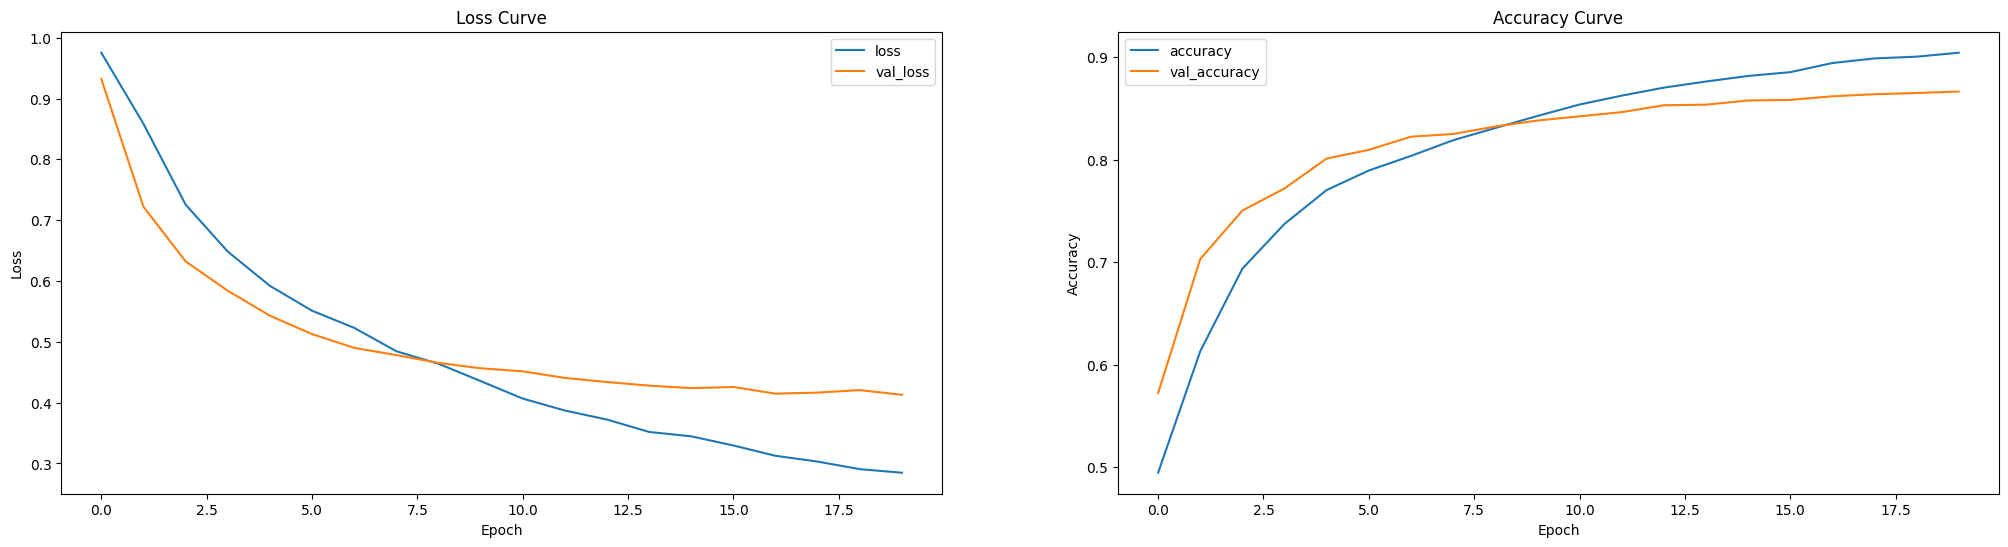

In [21]:
metrics = pd.DataFrame(model_imp_1_history.history)

fig, ax = plt.subplots(1, 2, figsize=(25, 6))
metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss Curve', xlabel='Epoch', ylabel='Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
plt.show()

In [22]:
# Get predicted class labels
imp_pred_train_seq = model_imp_1.predict(X_train_padded)
imp_pred_test_seq = model_imp_1.predict(X_test_padded)
imp_pred_train_1 = imp_pred_train_seq.argmax(axis=-1)
imp_pred_test_1 = imp_pred_test_seq.argmax(axis=-1)

# Calculate classification metrics
print(classification_report(np.argmax(ytrain, axis=1), imp_pred_train_1))
print(classification_report(np.argmax(ytest, axis=1), imp_pred_test_1))

108/108 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1721
           1       0.95      0.98      0.97      6431
           2       0.95      0.95      0.95      5550

    accuracy                           0.95     13702
   macro avg       0.94      0.92      0.93     13702
weighted avg       0.95      0.95      0.95     13702

              precision    recall  f1-score   support

           0       0.79      0.58      0.67       430
           1       0.87      0.92      0.89      1608
           2       0.88      0.89      0.89      1388

    accuracy                           0.87      3426
   macro avg       0.85      0.80      0.82      3426
weighted avg       0.86      0.87      0.86      3426



108/108 [==============================] - 1s 5ms/step


Text(70.72222222222221, 0.5, 'Actual')

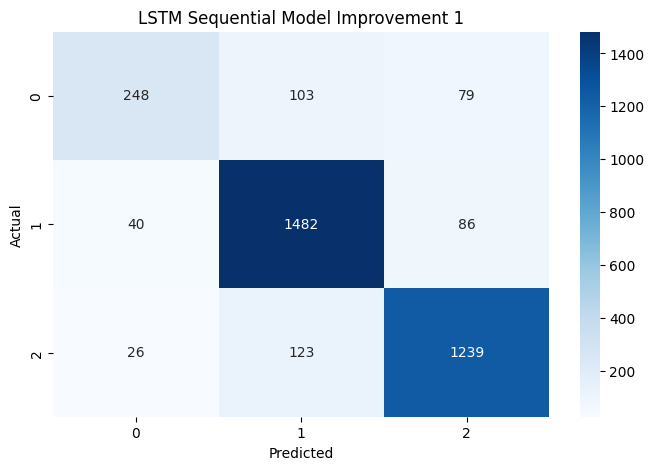

In [23]:
y_pred = model_imp_1.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(ytest, axis=1)

cm_imp_1 = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 5))
sns.heatmap(cm_imp_1,annot=True,fmt='d',cmap='Blues')
plt.title('LSTM Sequential Model Improvement 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')


penjelasan step pada model :
- Inisialisasi model Sequential dengan nama model_imp_1
- Menambahkan layer Embedding dengan parameter max_features, 50, dan input_length sesuai dengan ukuran data X_train_padded. Layer Embedding digunakan untuk mengubah representasi integer dari setiap kata dalam teks menjadi vektor numerik yang lebih kompak
- Menambahkan layer Conv1D dengan jumlah filter 18, kernel_size 3, padding 'same', dan aktivasi 'relu'. Layer Conv1D digunakan untuk melakukan operasi konvolusi pada vektor representasi kata.
- Menambahkan layer MaxPooling1D dengan pool_size 2. Layer MaxPooling1D digunakan untuk melakukan pooling pada hasil konvolusi yang diambil hanya nilai maksimum setiap 2 elemen.
- Menambahkan layer Dropout dengan tingkat dropout 0.5. Layer Dropout digunakan untuk mencegah overfitting pada model
- Menambahkan layer LSTM dengan 25 unit, dropout 0.5, dan recurrent_dropout 0.4. recurrent_dropout adalah tingkat dropout pada recurrent connections dalam LSTM.
- Menambahkan layer Dense dengan 3 unit dan aktivasi 'softmax'. Layer Dense ini bertugas mengklasifikasikan data menjadi 3 kelas berdasarkan hasil softmax.
- Compile model dengan memilih loss function categorical_crossentropy, optimizer tf.keras.optimizers.Adamax dengan learning rate 0.001, dan melihat accuracy sebagai metric evaluasi.
- Melatih model dengan fit method dengan data X_train_padded dan ytrain, melihat validasi pada data X_test_padded dan ytest, selama 20 epochs dengan batch_size 23. Callback EarlyStopping juga digunakan untuk menghentikan pelatihan apabila tidak ada peningkatan pada val_loss dalam jumlah patience (3).
  
model ini memberikan akurasi pada train set sebesat 0.95 dan pada test set 0.87, model ini dikatakan overfitting karena train set lebih tinggi dari test set dengan jarak lebih dari 0.05, pada confusion matrix model ini memprediksi benar label 0 (negatif) sebanyak 248, pada label 1 (neutral) sebanyak 1482 danpada label 2 (positif) sebanyak 1239.

### Model Improvement lstm sequential 2

In [24]:
model_imp_2 = Sequential()
model_imp_2.add(Embedding(max_features, 50, input_length=X_train_padded.shape[1]))
model_imp_2.add(Conv1D(filters=18, kernel_size=3, padding='same', activation='relu'))
model_imp_2.add(MaxPooling1D(pool_size=2))    
model_imp_2.add(Dropout(0.5))
model_imp_2.add(LSTM(25, dropout=0.5, recurrent_dropout=0.4))
model_imp_2.add(Dense(3, activation='softmax'))

model_imp_2.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0005, epsilon=1e-06), metrics=['accuracy'])
print(model_imp_2.summary())

model_imp_2_history = model_imp_2.fit(X_train_padded, ytrain, validation_data=(X_test_padded, ytest), epochs=20, batch_size=23, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 50)            500000    
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 18)            2718      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 18)            0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 5, 18)             0         
                                                                 
 lstm_3 (LSTM)               (None, 25)                4400      
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                      

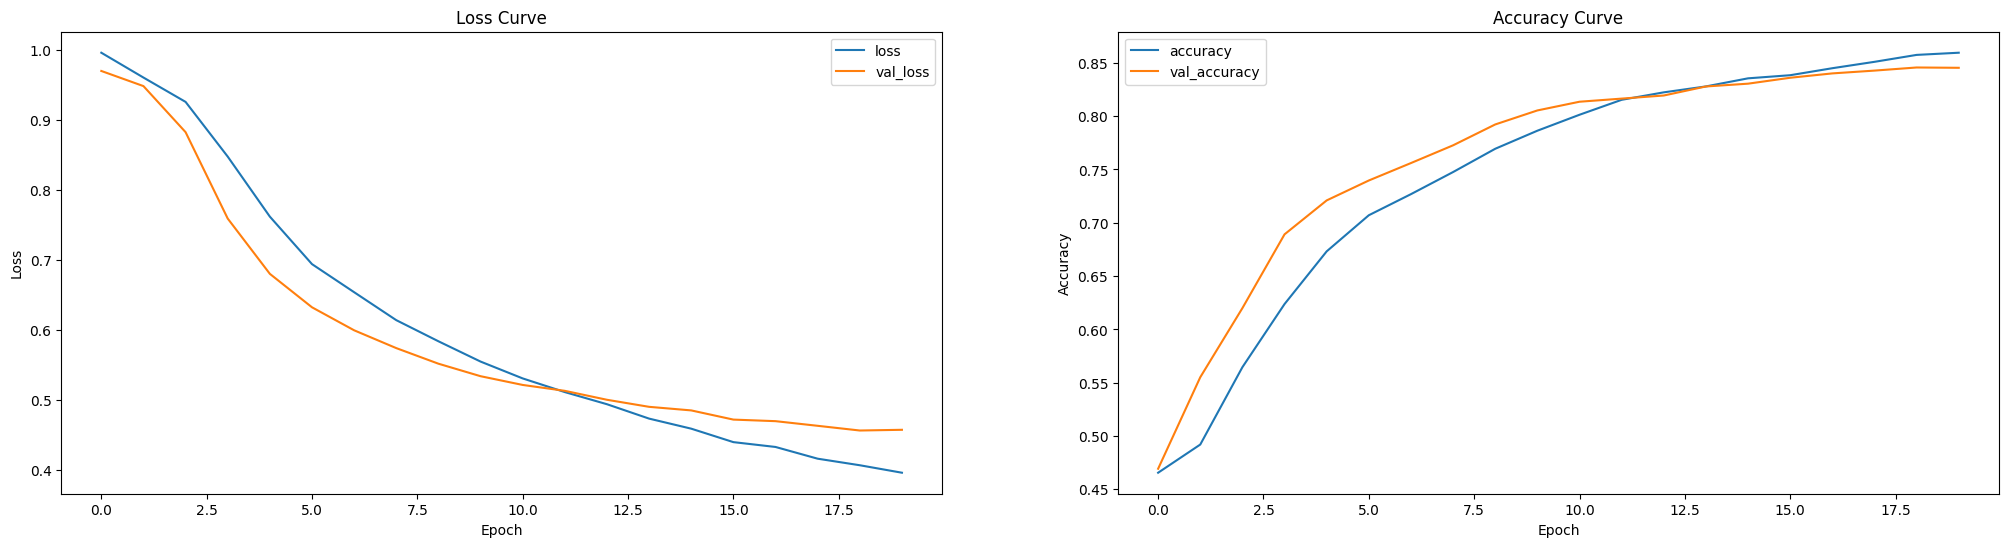

In [25]:
metrics = pd.DataFrame(model_imp_2_history.history)

fig, ax = plt.subplots(1, 2, figsize=(25, 6))
metrics[['loss', 'val_loss']].plot(ax=ax[0], title='Loss Curve', xlabel='Epoch', ylabel='Loss')
metrics[['accuracy', 'val_accuracy']].plot(ax=ax[1], title='Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
plt.show()

In [26]:
# Get predicted class labels
imp2_pred_train_seq = model_imp_2.predict(X_train_padded)
imp2_pred_test_seq = model_imp_2.predict(X_test_padded)
imp2_pred_train_1 = imp2_pred_train_seq.argmax(axis=-1)
imp2_pred_test_1 = imp2_pred_test_seq.argmax(axis=-1)

# Calculate classification metrics
print(classification_report(np.argmax(ytrain, axis=1), imp2_pred_train_1))
print(classification_report(np.argmax(ytest, axis=1), imp2_pred_test_1))

108/108 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.68      0.77      1721
           1       0.89      0.97      0.93      6431
           2       0.92      0.90      0.91      5550

    accuracy                           0.90     13702
   macro avg       0.90      0.85      0.87     13702
weighted avg       0.90      0.90      0.90     13702

              precision    recall  f1-score   support

           0       0.79      0.47      0.59       430
           1       0.84      0.93      0.88      1608
           2       0.86      0.86      0.86      1388

    accuracy                           0.85      3426
   macro avg       0.83      0.75      0.78      3426
weighted avg       0.84      0.85      0.84      3426



108/108 [==============================] - 1s 5ms/step


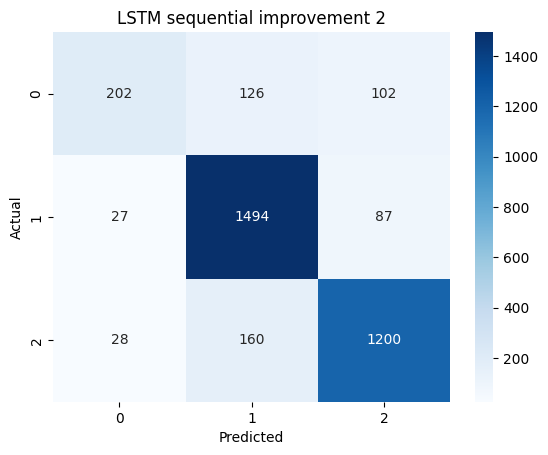

In [27]:
# Get predicted class labels
y_pred_train = model_imp_2.predict(X_train_padded).argmax(axis=-1)
y_pred_test = model_imp_2.predict(X_test_padded).argmax(axis=-1)

# Generate the confusion matrix for the test set
cm_imp_2 = confusion_matrix(ytest.argmax(axis=-1), y_pred_test)

sns.heatmap(cm_imp_2,annot=True,fmt='d',cmap='Blues')
plt.title('LSTM sequential improvement 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

penjelasan step pada model :
- Inisialisasi model Sequential dengan nama model_imp_1
- Menambahkan layer Embedding ke dalam model. Embedding layer digunakan untuk mengubah representasi integer dari kata-kata pada corpus menjadi representasi vektor. max_features adalah jumlah unik kata yang ada dalam corpus, 50 adalah jumlah fitur pada setiap vektor embedding, dan input_length=X_train_padded.shape[1] adalah panjang teks yang akan diterima oleh layer Embedding.
- Menambahkan layer Conv1D ke dalam model. Conv1D adalah layer Convolutional Neural Network (CNN) dengan dimensi 1D. filters adalah jumlah filter yang akan digunakan, kernel_size adalah ukuran kernel yang akan digunakan, padding='same' berarti bahwa setiap elemen dari teks akan diamati oleh setidaknya satu filter, dan activation='relu' berarti bahwa fungsi aktivasi yang digunakan adalah ReLU (Rectified Linear Unit).
- Menambahkan layer MaxPooling1D ke dalam model. MaxPooling1D adalah layer yang digunakan untuk mengurangi ukuran representasi teks. pool_size=2 berarti bahwa setiap 2 elemen akan dikombinasikan menjadi 1 elemen saja.
- Menambahkan layer Dropout ke dalam model. Dropout adalah layer yang digunakan untuk mencegah overfitting pada model. Nilai 0.5 berarti bahwa setiap 50% dari bobot yang ada pada model akan direset menjadi 0 secara acak pada setiap epoch.
- Menambahkan layer LSTM (Long Short-Term Memory) ke dalam model. LSTM adalah layer yang digunakan untuk memproses secara sekuensial. Nilai 25 adalah jumlah unit pada setiap layer LSTM, dropout=0.5 berarti bahwa setiap 50% dari bobot yang ada pada layer LSTM akan direset menjadi 0 secara acak pada setiap epoch, dan recurrent_dropout=0.4.
  
model ini memberikan akurasi pada train set sebesar 0.90 dan pada test set 0.85 sehingga bisa dikatak model ini goodfit, model ini berhasil memprediksi benar pada label 0 (negatif) sebanyak 202, pada label 1 (neutral) sebanyak 1494 dan pada label 2 (positif) sebanyak 1200.

karena model ini adalah model yang paling bagus maka akan dipakai untuk model inference dan model deployment.

# Model Save

In [28]:
# Freezing
model_imp_2.trainable = False
model_imp_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 50)            500000    
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 18)            2718      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 18)            0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 5, 18)             0         
                                                                 
 lstm_3 (LSTM)               (None, 25)                4400      
                                                                 
 dense_2 (Dense)             (None, 3)                 78        
                                                      

In [29]:
model_imp_2.save('model.h5') # Save model

# Pengambilan Kesimpulan

Project ini menggunakan dataset bitcoin tweet yang berisikan sentimen seseorang terhadap bitcoin, dalam project ini saya mengklasifikasikan apakah seseorang memiliki sentimen negatif, neutral atau positif atas postingannya terhadap bitcoin.

pada dataset ini terdapat 3 label pada olom label, yaitu neutral, positive dan negative, dimana label terbanyak ada pada label positive sebesar 22937 dan terendah adalah label negative sebanyak 5983 dan dilanjut kan dengan melakukan preprocessing seperti penghapusan kata yagn tidak dibutuhkan seperti emoji, karakter(.,;) dll.

Setelah dilakukan preprocessing jumlah dari masing masing label berubah, untuk label positive menjadi 22205 yang asalnya 22937, neutral dari 21939 menjadi 19860 dan negative menjadi 5800 yang asalnya 5983, namun jumlah terbanyak masih terdapat pada label positive dan terendah tetap berada di negative, label terbanyak yang kehilangan datanya adalah label neutral dengan jumlah data dihapus 2079 karena memiliki duplikasi data, duplikasi data dihapus karena untuk mencegah bias dalam analisis. Jika data duplikat tidak dihapus, kemungkinan besar data tersebut akan diberikan bobot yang lebih besar daripada data unik saat dilakukan analisis, sehingga dapat mempengaruhi hasil analisis dan memberikan kesimpulan yang salah.

kata terbanyak pada dataset ini adalah :

- Kata Positif paling banyak adalah bitcoin sathoshi, new airdrop, airdrop new, hampir semua kata positif didominasi oleh kata airdrop, yang dimana airdrop menurut zipmex.com adalah airdrop adalah pemberian crypto asset pada sebagian orang atau komunitas yang diberikan secara cuma-cuma.

- Kata Negative paling banyak adalah supply volume, total supply, change price, price rank
- Kata netral paling banyak adalah find celebrate, bitcointalk, click aicle

# Overall Model Analysis

setelah dilakukan improvement, model terbaik adalah model sequential improvement 2 karena memiliki akurasi train set sebesar 0.90 dan test set 0.85 dan model ini satu satunya model yang goodfit, meskipun base model sequential ini memiliki akurasi paling tinggi taitu 0.88 untuk test set dan 0.95 untuk train set, model ini mengalami overfitting, perubahan yang dilakukan pada base model dan improvement model adalah untuk base model hanya menggunakan LSTM, dan untuk improvement model digunakan CNN + LSTM, perbedaan antara model improvement 1 dan 2 terdapat pada learning rate dimana learning rate untuk model improvement 1 sebesar 0.001, dan pada model improvement 2 sebesar 0.0005, perbedaan ini sangat berpengah pada model karena saat learning rate kecil, perubahan pada bobot dalam model akan lebih kecil dan lebih stabil, sehingga model lebih mungkin untuk menemukan solusi yang optimal, dan perbedaan lainnya adalah adanya epsilon sebesar 1e-06 pada model improvement 2, epsilon digunakan sebagai batas minimum untuk perubahan pada learning rate. Jika perubahan pada learning rate di bawah nilai epsilon, maka learning rate tidak akan berubah lagi seiring dengan perkembangan proses pembelajaran (training).

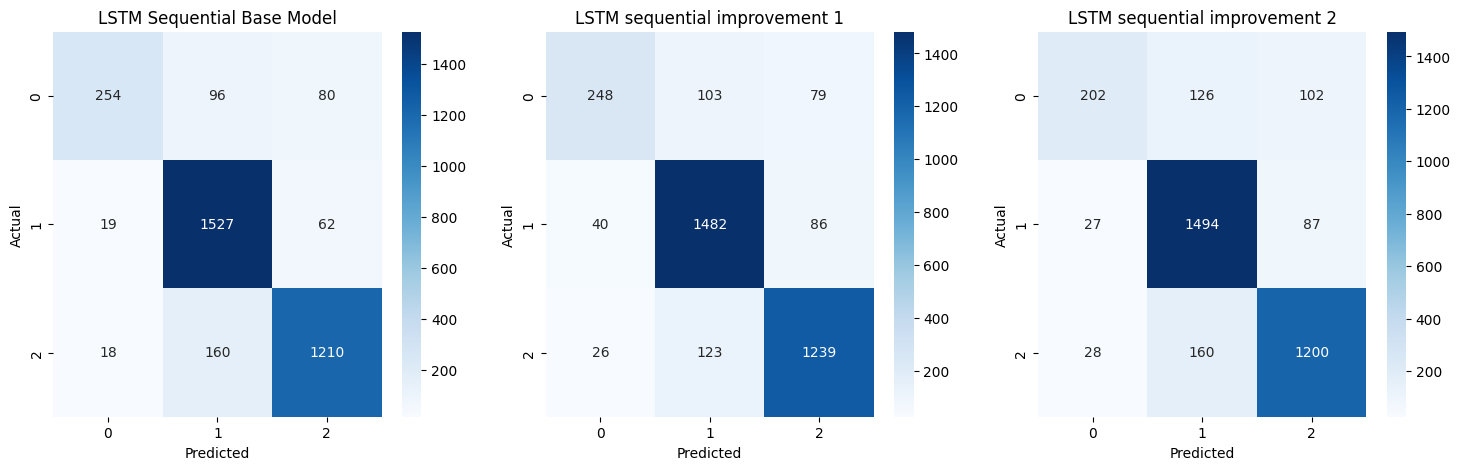

In [30]:
cm_bm = confusion_matrix(np.argmax(ytest, axis=1), y_pred1)
cm_imp_1 = confusion_matrix(y_true, y_pred)
cm__imp_2 = confusion_matrix(ytest.argmax(axis=-1), y_pred_test)

plt.figure(figsize=(18, 5))

plt.subplot(1,3,1)
sns.heatmap(cm_bm,annot=True,fmt='d',cmap='Blues')
plt.title('LSTM Sequential Base Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.subplot(1,3,2)
sns.heatmap(cm_imp_1,annot=True,fmt='d',cmap='Blues')
plt.title('LSTM sequential improvement 1')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1,3,3)
sns.heatmap(cm__imp_2,annot=True,fmt='d',cmap='Blues')
plt.title('LSTM sequential improvement 2')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

pada confusion matrix diatas base model memiliki true positif terbanyak dengan jumlah 1527, dam paling sedikit adalah improvement 1 dengan jumlah 1482, namun dari semua model ini semuanya memiliki true positif pada label 2 (positif) dan label 1 (neutral) yang hampir sama banyaknya karena pada dataset ini didominasi oleh label 1 (neutral) dan label 2 (positif) sedangkan untuk label 0 (negatif) jumlahnya sangat sedikit sehingga wajar jika pada confusion matrix jumlah prediksi untuk label 0 ini hanya sedikit. 

## Apa maksud dari performansi yang didapatkan baik saat training maupun testing ?

Performansi dapat dikatakan baik adalah ketika data training mendapatkan selisih yang kecil dengan data test seperti pada training set mendapatkan akurasi sebesar 0.91 dan pada data test mendapatkan akurasi yang sama atau 0.92, ini dikatakan baik karena goodfit.

## Penjelasan Arsitektur improved

arsitektur improved dilakukan ketika data pada base model atau model yang sudah diimprove memiliki hasil yang tidak maksimal seperti adanya overfitting, sehingga dilakukan improvement dengan menggunakan layers droput, epsilon, learning rate untuk mengurangi overfitting